In [1]:
from snn_delays.snn_refactoring_minimal_v4 import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.train_utils_refact_minimal import train, get_device, propagate_batch_simple, to_plot
from snn_delays.utils.test_behavior import tb_addtask
# from snn_delays.utils.visualization_utils import plot_taus
import numpy as np
device = get_device()

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda:0


In [2]:
time_window = 50
batch_size = 128 # 128: anil kag

ckpt_dir = 'addtask_03_2025_tests'

dataset = 'addtask_episodic'
#dataset = 'addtask' 

DL = DatasetLoader(dataset=dataset, caching='', num_workers=0, batch_size=batch_size, total_time=time_window)
train_loader, test_loader, dataset_dict = DL.get_dataloaders()
dataset_dict["time_ms"] = 2e3

In [3]:
num_h = 128

snn_f = SNN(dataset_dict, structure=(num_h, 1, 'f'), win=time_window,
             loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=False)

snn_f.set_layers()
snn_f.num_train_samples = batch_size
snn_f.to(device)

snn_rnn = SNN(dataset_dict, structure=(num_h, 1, 'r'), win=time_window,
               loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=False)

snn_rnn.set_layers()
snn_rnn.num_train_samples = batch_size
snn_rnn.to(device)


2000.0
Delta t: 40.0 ms
mean of normal: -1.8545865421311407
2000.0
Delta t: 40.0 ms
mean of normal: -1.8545865421311407
2000.0
Delta t: 40.0 ms
mean of normal: -1.8545865421311407
2000.0
Delta t: 40.0 ms
mean of normal: -1.8545865421311407


SNN(
  (criterion): MSELoss()
  (layers): ModuleList(
    (0): RecurrentSNNLayer(
      (linear): Linear(in_features=2, out_features=128, bias=False)
      (linear_rec): Linear(in_features=128, out_features=128, bias=False)
    )
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=128, out_features=1, bias=False)
    )
  )
)

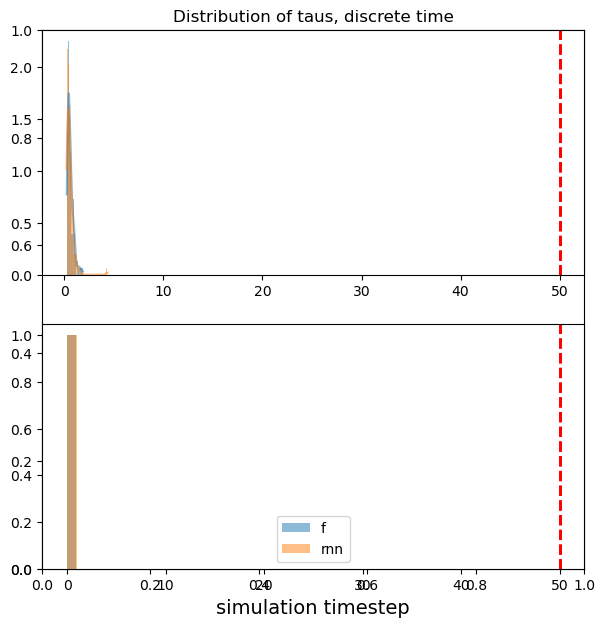

In [4]:
import matplotlib.pyplot as plt
from snn_delays.utils.visualization_utils import plot_param
import torch

def plot_taus(snn, label = 'taus', mode='discrete'):

    '''
    mode: real or discrete
    '''

    delta_t = snn.dataset_dict.get('time_ms', 0)/snn.win

    tau_m_params = [param for name, param in snn.named_parameters() if 'tau' in name]

    num_subplots = len(tau_m_params)

    plt.title(f'Distribution of taus, {mode} time')
    for i, pseudo_tau_m in enumerate(tau_m_params):

        real_tau = -delta_t/torch.log(torch.sigmoid(pseudo_tau_m))

        if mode=='real':
            plt.subplot(num_subplots, 1, i+1)
            plot_param(real_tau, mode='histogram', label=label, distribution='kde')
            if i==num_subplots-1:
                plt.xlabel('time (ms)')

        elif mode=='discrete':
            plt.subplot(num_subplots, 1, i+1)
            #plot_param(real_tau/snn.win, mode='histogram')    
            plot_param(real_tau/delta_t, mode='histogram', label=label, distribution='kde')
            plt.axvline(x=snn.win, color='red', linestyle='--', linewidth=2)
    #        plt.xlim(0, snn.win)
            if i==num_subplots-1:
                plt.xlabel('simulation timestep')

        else:
            raise ValueError(f"Unsupported: {mode}. Choose from 'real', 'discrete'.")

plt.figure(figsize=(7,7))
plot_taus(snn_f, label='f')
plot_taus(snn_rnn, label='rnn')
plt.legend()

In [5]:
snn_f

SNN(
  (criterion): MSELoss()
  (layers): ModuleList(
    (0): FeedforwardSNNLayer(
      (linear): Linear(in_features=2, out_features=128, bias=False)
    )
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=128, out_features=1, bias=False)
    )
  )
)

In [6]:
snn_rnn

SNN(
  (criterion): MSELoss()
  (layers): ModuleList(
    (0): RecurrentSNNLayer(
      (linear): Linear(in_features=2, out_features=128, bias=False)
      (linear_rec): Linear(in_features=128, out_features=128, bias=False)
    )
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=128, out_features=1, bias=False)
    )
  )
)

In [7]:
lr_tau = 0.1
train(snn_f, train_loader, test_loader, 1e-3, 1000, ckpt_dir=ckpt_dir, test_behavior=tb_addtask, scheduler=(100, 0.95), clear=True, lr_tau=lr_tau)
train(snn_rnn, train_loader, test_loader, 1e-3, 1000, ckpt_dir=ckpt_dir, test_behavior=tb_addtask, scheduler=(100, 0.95), clear=True, lr_tau=lr_tau)

Mean Error: 0.0010359351290389895% 
--------------------------


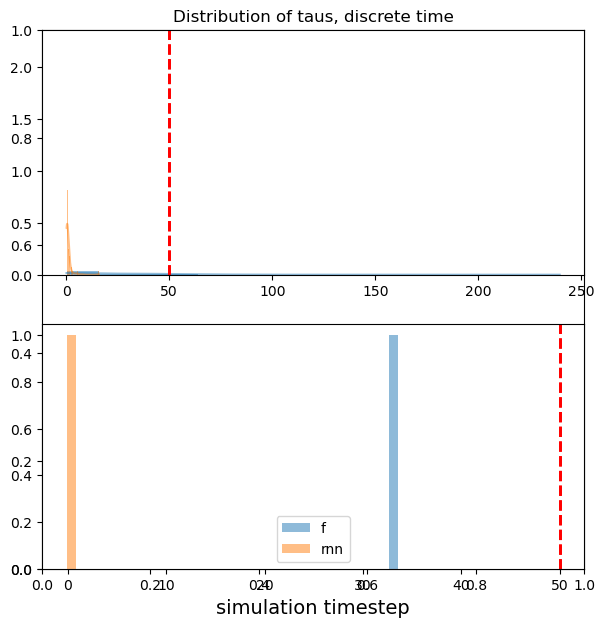

In [8]:
plt.figure(figsize=(7,7))
plot_taus(snn_f, label='f')
plot_taus(snn_rnn, label='rnn')
plt.legend()

Text(0.5, 1.0, 'train loss')

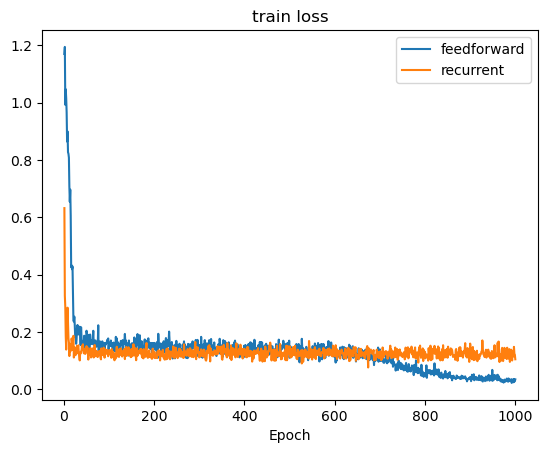

In [9]:
import numpy as np
from snn_delays.utils.visualization_utils import plot_per_epoch
loss_error = np.mean(np.array(snn_f.train_loss)[:,1][-100:])
plot_per_epoch(snn_f.train_loss, label = 'feedforward')
plot_per_epoch(snn_rnn.train_loss, label = 'recurrent')
#plt.title(f'loss error = {loss_error}')

#plt.ylim(0, loss_error)
plt.title('train loss')

In [10]:
snn_f.debug = True
snn_rnn.debug = True
snn_f.init_state_logger()
snn_rnn.init_state_logger()

from snn_delays.utils.train_utils_refact_minimal import propagate_batch_simple
images, labels_mf = propagate_batch_simple(snn_f, test_loader)
_, labels_rnn = propagate_batch_simple(snn_rnn, test_loader)

In [11]:
ref_mf = labels_mf[:,:int(0.1*time_window),0].T.cpu().numpy()
out_mf = snn_f.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()

ref_rnn = labels_rnn[:,:int(0.1*time_window),0].T.cpu().numpy()
out_rnn = snn_rnn.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()


-0.046374448
-0.05508716


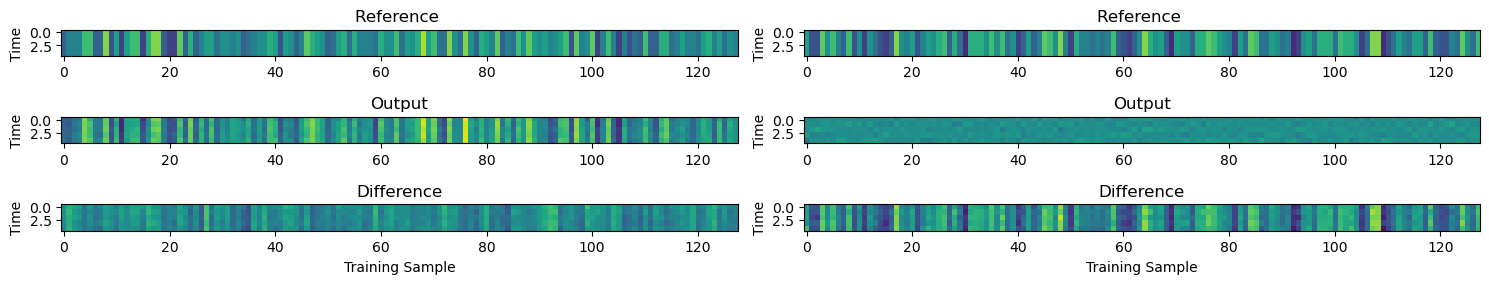

In [12]:
from snn_delays.utils.visualization_utils import plot_add_task, plot_add_task2, plot_add_task3, plot_add_task4
# Create a figure with 3 rows and N columns (for stacking results horizontally)
fig, axes = plt.subplots(3, 2, figsize=(15, 3))  # 3 rows, 2 columns

plot_add_task(out_mf, ref_mf, axes[:, 0])  
plot_add_task(out_rnn, ref_rnn, axes[:, 1])  

plt.tight_layout()
plt.show()

<Axes: xlabel='Index', ylabel='Value'>

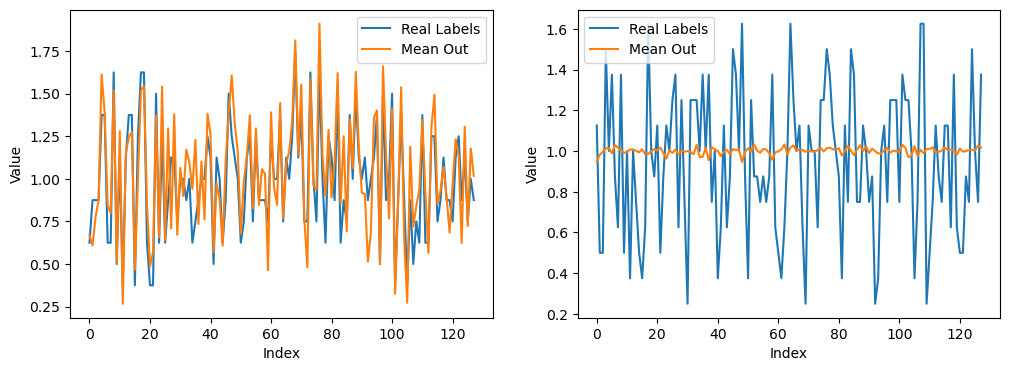

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_add_task2(out_mf, labels_mf)
plt.subplot(122)
plot_add_task2(out_rnn, labels_rnn)

<Axes: title={'center': 'output'}, xlabel='training sample', ylabel='time'>

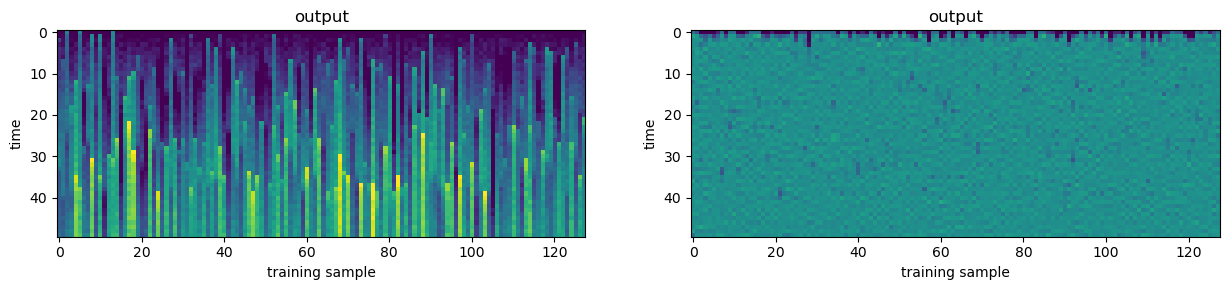

In [14]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
plot_add_task3(snn_f)
plt.subplot(122)
plot_add_task3(snn_rnn)

<Axes: title={'center': 'Dynamics of neuron = 0 of the layer output'}, xlabel='Time (ms)', ylabel='Membrane potential (mV)'>

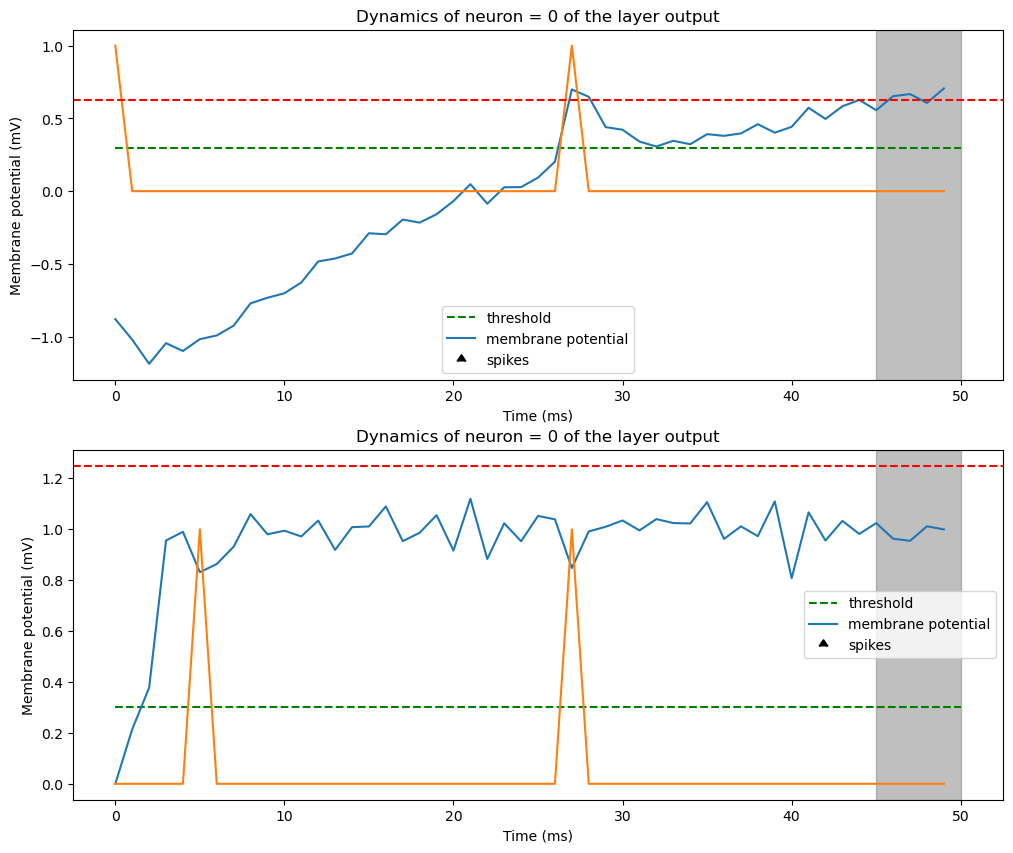

In [15]:
plt.figure(figsize=(12, 10))

sample_number = 25

plt.subplot(211)
plot_add_task4(snn_f, sample_number)
plt.subplot(212)
plot_add_task4(snn_rnn, sample_number)
